# COOKIE CATS A/B TEST

## Target Metric: 

### sum_gamerounds with Retention
    The total number of game rounds played by a user in the first 14 days after installation.

### Why this Metric?

1. Directly Measures Engagement:
    * A higher number of game rounds indicates that players are more engaged with the game.
    * Engagement is a key goal for game developers, as it often leads to increased player retention and revenue.

2. Measurable and Comparable:
    * sum_gamerounds is a continuous numeric variable, making it ideal for comparisons between the gate_30 and gate_40 groups.
    * This metric captures the immediate impact of moving the gate in the game.

3. Aligned with Test Goal:
    * The stated goal of the test is to determine whether moving the first gate from level 30 to level 40 affects player engagement.
    * By analyzing the total rounds played, we can infer whether the gate placement positively or negatively impacts player behavior

### How it Measures Progress 

- Comparison Between Groups:
    * By comparing the mean number of game rounds played (sum_gamerounds) between the control (gate_30) and treatment (gate_40) groups, we can assess the impact of the gate change.

- Long-Term Impact:
    * If the treatment group (gate_40) shows significantly higher sum_gamerounds, it suggests the gate change positively influences player engagement.

- Complementary Metrics:
    * While sum_gamerounds is the primary metric, we can use retention rates (retention_1 and retention_7) as secondary metrics to validate the results.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, shapiro, levene, chisquare, ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

## Loading Dataset

In [2]:
file_path = "cookie_cats.csv"
df = pd.read_csv(file_path)

print(df.info())
df.head(8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False


### Check for duplicates

In [3]:
duplicate_rows = df[df.duplicated()]

duplicate_users = df[df.duplicated(subset=["userid"], keep=False)]

print(f"Total duplicate rows: {len(duplicate_rows)}")
print(f"Total duplicate user IDs: {len(duplicate_users)}")

Total duplicate rows: 0
Total duplicate user IDs: 0


### Check for Outliers using threshold

In [4]:
threshold = df["sum_gamerounds"].quantile(0.99)

extreme_players = df[df["sum_gamerounds"] > threshold]

print(f"Number of extreme players detected: {len(extreme_players)}")
print(f"Top threshold for game rounds (99th percentile): {threshold}")

Number of extreme players detected: 898
Top threshold for game rounds (99th percentile): 493.0


## Sample size and Variant Proportions

In [5]:
sample_size = df["version"].value_counts()
print("Sample Size per Variant:")
print(sample_size)


variant_proportions = df["version"].value_counts(normalize=True) * 100
print("\nVariant Proportions (%):")
print(variant_proportions)

Sample Size per Variant:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Variant Proportions (%):
version
gate_40    50.437415
gate_30    49.562585
Name: proportion, dtype: float64


The sample sizes are relatively balanced between the two variants. While there is a slight difference, such variations are expected in randomized experiments due to natural randomness during user allocation. 

The proportions are very close to the ideal 50%-50% split, suggesting that the randomization process worked as intended. This slight deviation (0.88 percentage points) is not statistically concerning.

## Exploratory Data Analysis

### Summary Stats

In [6]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
             userid  sum_gamerounds
count  9.018900e+04    90189.000000
mean   4.998412e+06       51.872457
std    2.883286e+06      195.050858
min    1.160000e+02        0.000000
25%    2.512230e+06        5.000000
50%    4.995815e+06       16.000000
75%    7.496452e+06       51.000000
max    9.999861e+06    49854.000000


### Distribution of game rounds

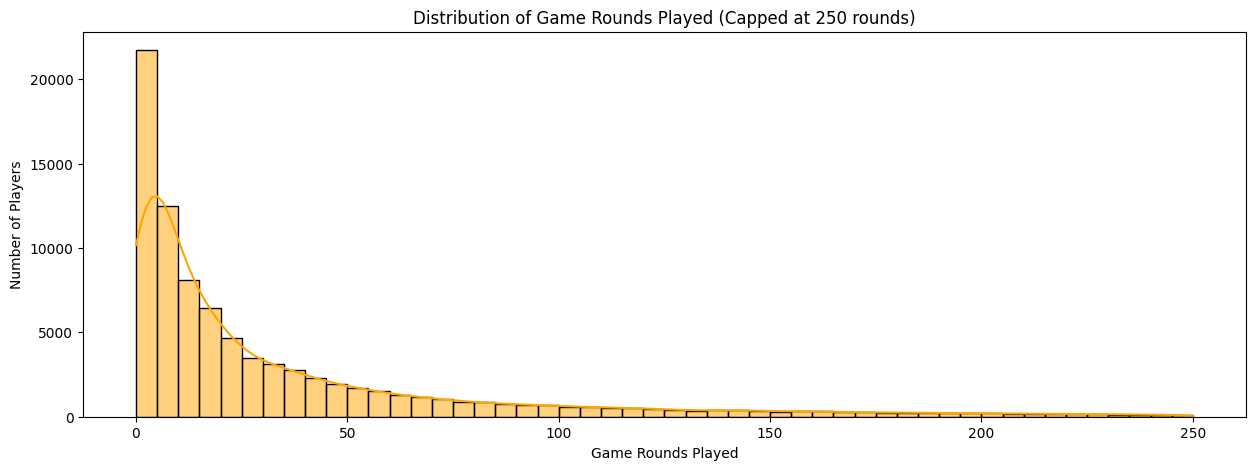

In [7]:
upper_limit_adjusted = 250

plt.figure(figsize=(15, 5))
sns.histplot(
    df[df["sum_gamerounds"] <= upper_limit_adjusted]["sum_gamerounds"],
    bins=50,
    kde=True,
    color="orange",
)

plt.xlabel("Game Rounds Played")
plt.ylabel("Number of Players")
plt.title(
    f"Distribution of Game Rounds Played (Capped at {upper_limit_adjusted} rounds)"
)
plt.show()

**Right-Skewed Distribution:**
- Most players played only a few rounds.
- A large spike at low game rounds indicates that many players played only a handful of rounds before stopping.

**Gradual Decline:**
- The number of players decreases as game rounds increase.
- This suggests player drop-off over time.

The game loses most players early.
A small percentage of users play a lot, but they are not the majority.

If we are analyzing player retention, focusing on the first few game rounds is crucial.

### Retention Rates for only players who made it to Gates. 

<Figure size 1500x500 with 0 Axes>

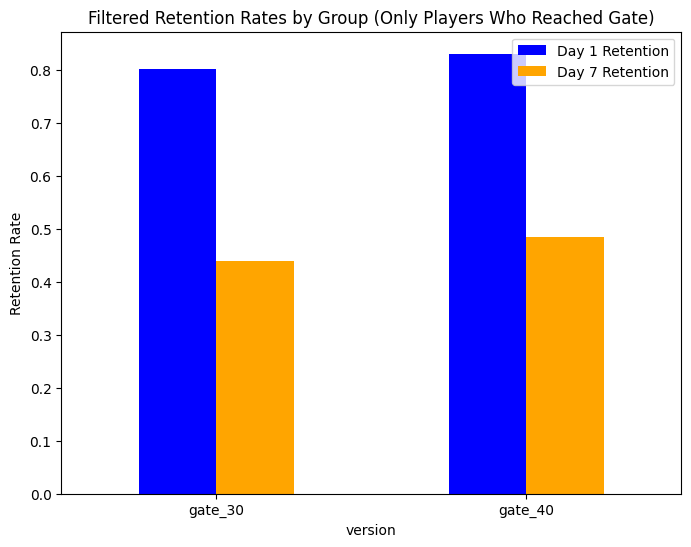

In [8]:
gate_30_threshold = 30
gate_40_threshold = 40

df_filtered = df[
    ((df["version"] == "gate_30") & (df["sum_gamerounds"] >= gate_30_threshold))
    | ((df["version"] == "gate_40") & (df["sum_gamerounds"] >= gate_40_threshold))
]

retention_rates_filtered = df_filtered.groupby("version")[
    ["retention_1", "retention_7"]
].mean()

plt.figure(figsize=(15, 5))
retention_rates_filtered.plot(kind="bar", figsize=(8, 6), color=["blue", "orange"])
plt.title("Filtered Retention Rates by Group (Only Players Who Reached Gate)")
plt.ylabel("Retention Rate")
plt.xticks(rotation=0)
plt.legend(["Day 1 Retention", "Day 7 Retention"])
plt.show()

**Day 1 Retention:**
- Players in both groups show a high first-day retention rate (~80-85%), indicating that many players return the next day.
The retention rate is slightly higher for `gate_40`, suggesting that players who reached level 40 might be more engaged.

**Day 7 Retention:**
- Retention after 7 days is significantly lower (~45-48%), which is expected.
Again, `gate_40` has a slightly higher 7-day retention rate compared to `gate_30`, suggesting players who experienced a later gate might be more likely to stay engaged.

A higher retention rate for `gate_40` suggests that delaying the gate might improve player engagement.


### Game Rounds Distribution for Engaged Players

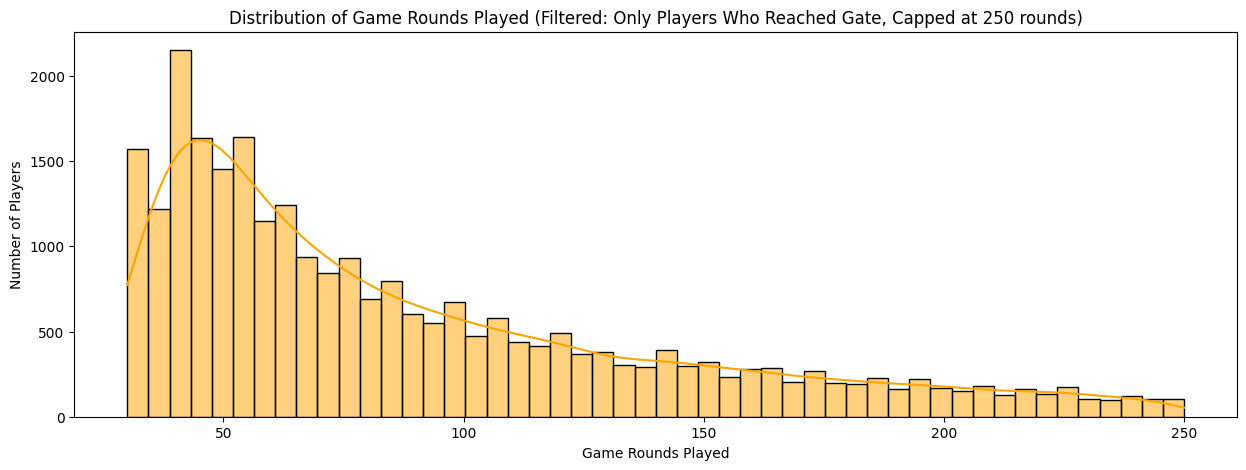

In [9]:
upper_limit_adjusted = 250  # Capping at 250 rounds

plt.figure(figsize=(15, 5))
sns.histplot(
    df_filtered[df_filtered["sum_gamerounds"] <= upper_limit_adjusted][
        "sum_gamerounds"
    ],
    bins=50,
    kde=True,
    color="orange",
)

plt.xlabel("Game Rounds Played")
plt.ylabel("Number of Players")
plt.title(
    f"Distribution of Game Rounds Played (Filtered: Only Players Who Reached Gate, Capped at {upper_limit_adjusted} rounds)"
)
plt.show()

The peak occurs around 30-50 rounds, which makes sense because these players had to reach the gate to be included.

The distribution still follows a right-skewed pattern, meaning most players play a relatively low number of rounds, and only a few engage in very high gameplay.

Compared to the original distribution (which included all users), this one is more centered on engaged players, removing early dropouts who might have distorted the scale.


## SRM Detection

In [10]:
observed_counts = df["version"].value_counts()

expected_counts = [len(df) / 2] * 2  # Assuming 50-50 split

chi2_stat, p_val = chisquare(f_obs=observed_counts, f_exp=expected_counts)

print(f"Chi-Square Test for SRM:")
print(f"Chi2 Statistic = {chi2_stat:.4f}, P-value = {p_val:.4f}")

if p_val < 0.05:
    print("Sample Ratio Mismatch detected. Investigate further before proceeding.")
else:
    print("No Sample Ratio Mismatch detected. Proceed with the analysis.")

Chi-Square Test for SRM:
Chi2 Statistic = 6.9024, P-value = 0.0086
Sample Ratio Mismatch detected. Investigate further before proceeding.


### Resampling to handle Sample Ratio Mismatch

In [11]:
min_sample_size = df["version"].value_counts().min()

gate_30_sample = resample(
    df[df["version"] == "gate_30"], n_samples=min_sample_size, random_state=42
)
gate_40_sample = resample(
    df[df["version"] == "gate_40"], n_samples=min_sample_size, random_state=42
)

df_balanced = pd.concat([gate_30_sample, gate_40_sample])

observed_counts_balanced = df_balanced["version"].value_counts()
expected_counts_balanced = [min_sample_size, min_sample_size]

chi2_stat_balanced, p_val_balanced = chisquare(
    f_obs=observed_counts_balanced, f_exp=expected_counts_balanced
)

print(
    f"Balanced SRM Chi-Square Test: Chi2 Statistic = {chi2_stat_balanced:.4f}, P-value = {p_val_balanced:.4f}"
)

Balanced SRM Chi-Square Test: Chi2 Statistic = 0.0000, P-value = 1.0000


## Metric Comparison for A/B Test

## Statistical Tests

### Variance Equality (Levene's test)

In [12]:
df_engaged = df[
    ((df["version"] == "gate_30") & (df["sum_gamerounds"] >= 30))
    | ((df["version"] == "gate_40") & (df["sum_gamerounds"] >= 40))
]

gate_30_engaged = df_engaged[df_engaged["version"] == "gate_30"]["sum_gamerounds"]
gate_40_engaged = df_engaged[df_engaged["version"] == "gate_40"]["sum_gamerounds"]

levene_test_engaged = levene(gate_30_engaged, gate_40_engaged)

print(f"\nLevene's Test for Equality of Variances (Engaged Players):")
print(
    f"Statistic = {levene_test_engaged.statistic:.4f}, P-value = {levene_test_engaged.pvalue:.4f}"
)

if levene_test_engaged.pvalue < 0.05:
    print("The variances are significantly different between the two groups.")
else:
    print("No significant difference in variances between the two groups.")


Levene's Test for Equality of Variances (Engaged Players):
Statistic = 0.6970, P-value = 0.4038
No significant difference in variances between the two groups.


- The assumption of equal variances holds for statistical tests like the t-test.

- This confirms that the engagement patterns between the two groups are comparable in terms of variance.

### Kolmogorov-Smirnov (KS) Test Results (Engaged Players Only)

In [13]:
ks_test = ks_2samp(gate_30_engaged, gate_40_engaged)

print(f"\nKolmogorov-Smirnov Test for Distribution Comparison (Engaged Players):")
print(f"Statistic = {ks_test.statistic:.4f}, P-value = {ks_test.pvalue:.4f}")

if ks_test.pvalue < 0.05:
    print("The distributions of gate_30 and gate_40 are significantly different.")
else:
    print("No significant difference in the distributions of gate_30 and gate_40.")


Kolmogorov-Smirnov Test for Distribution Comparison (Engaged Players):
Statistic = 0.1869, P-value = 0.0000
The distributions of gate_30 and gate_40 are significantly different.


- Players in `gate_30` and `gate_40` do not follow the same gameplay pattern.

- This suggests that moving the gate from level 30 to level 40 altered player behavior.
Further investigation is needed to understand how exactly the distributions differ

### Engagement: `sum_gamerounds`

In [14]:
t_stat_engaged, p_val_engaged = ttest_ind(
    gate_30_engaged, gate_40_engaged, equal_var=False
)

print(f"\nT-Test for sum_gamerounds (Engaged Players Only):")
print(f"T-statistic = {t_stat_engaged:.4f}, P-value = {p_val_engaged:.4f}")

if p_val_engaged < 0.05:
    print(
        "There is a significant difference in game rounds played between gate_30 and gate_40 groups."
    )
else:
    print(
        "No significant difference in game rounds played between gate_30 and gate_40 groups."
    )


T-Test for sum_gamerounds (Engaged Players Only):
T-statistic = -5.1289, P-value = 0.0000
There is a significant difference in game rounds played between gate_30 and gate_40 groups.


- Players in `gate_40` (who saw the gate later) played significantly fewer rounds than those in `gate_30`.

- This suggests that moving the gate to level 40 may have negatively impacted engagement.

### Retention: `retention_1` and `retention_7` 

In [15]:
retention_1_success_engaged = df_engaged.groupby("version")["retention_1"].sum()
retention_1_total_engaged = df_engaged.groupby("version")["retention_1"].count()

retention_7_success_engaged = df_engaged.groupby("version")["retention_7"].sum()
retention_7_total_engaged = df_engaged.groupby("version")["retention_7"].count()

z_stat_1_engaged, p_val_1_engaged = proportions_ztest(
    count=retention_1_success_engaged, nobs=retention_1_total_engaged
)
z_stat_7_engaged, p_val_7_engaged = proportions_ztest(
    count=retention_7_success_engaged, nobs=retention_7_total_engaged
)

print(
    f"\nZ-Test for Retention Day 1 (Engaged Players Only): Z-stat = {z_stat_1_engaged:.4f}, P-value = {p_val_1_engaged:.4f}"
)
print(
    f"Z-Test for Retention Day 7 (Engaged Players Only): Z-stat = {z_stat_7_engaged:.4f}, P-value = {p_val_7_engaged:.4f}"
)

for day, z_stat, p_val in [
    ("Day 1", z_stat_1_engaged, p_val_1_engaged),
    ("Day 7", z_stat_7_engaged, p_val_7_engaged),
]:
    if p_val < 0.05:
        print(f"Retention {day}: Significant difference between gate_30 and gate_40.")
    else:
        print(
            f"Retention {day}: No significant difference between gate_30 and gate_40."
        )


Z-Test for Retention Day 1 (Engaged Players Only): Z-stat = -6.5291, P-value = 0.0000
Z-Test for Retention Day 7 (Engaged Players Only): Z-stat = -8.0758, P-value = 0.0000
Retention Day 1: Significant difference between gate_30 and gate_40.
Retention Day 7: Significant difference between gate_30 and gate_40.


- There is a statistically significant difference in both **Day 1** and **Day 7 retention rates** between `gate_30` and `gate_40`.

- The negative Z-statistic suggests that retention in `gate_40` is lower compared to `gate_30`.

- This indicates that moving the gate from level 30 to level 40 negatively impacted player retention.


## Treatment Effect and Confidence Interval

In [16]:
retention_7_gate_30_engaged = df_engaged[df_engaged["version"] == "gate_30"][
    "retention_7"
]
retention_7_gate_40_engaged = df_engaged[df_engaged["version"] == "gate_40"][
    "retention_7"
]

treatment_effect_engaged = (
    retention_7_gate_30_engaged.mean() - retention_7_gate_40_engaged.mean()
)

n_30_engaged = len(retention_7_gate_30_engaged)
n_40_engaged = len(retention_7_gate_40_engaged)

std_30_engaged = retention_7_gate_30_engaged.std()
std_40_engaged = retention_7_gate_40_engaged.std()

se_diff_engaged = np.sqrt(
    (std_30_engaged**2 / n_30_engaged) + (std_40_engaged**2 / n_40_engaged)
)

ci_low_analytical_engaged = treatment_effect_engaged - 1.96 * se_diff_engaged
ci_high_analytical_engaged = treatment_effect_engaged + 1.96 * se_diff_engaged

print(
    f"\nTreatment Effect (Day 7 Retention - Engaged Players): {treatment_effect_engaged:.4f}"
)
print(
    f"Analytical Confidence Interval: ({ci_low_analytical_engaged:.4f}, {ci_high_analytical_engaged:.4f})"
)


Treatment Effect (Day 7 Retention - Engaged Players): -0.0463
Analytical Confidence Interval: (-0.0575, -0.0351)


- The negative treatment effect confirms that moving the gate from `gate_30` to `gate_40` had a **negative** impact on **retention**.

- Since the confidence interval does not include zero, this suggests the effect is statistically significant.

Players in `gate_40` had **lower 7-day retention** compared to `gate_30` players, reinforcing previous results.


### Bootstrap Confidence Interval 

In [17]:
n_boot = 10000
boot_diffs_engaged = []

for _ in range(n_boot):
    boot_30 = np.random.choice(
        retention_7_gate_30_engaged, size=n_30_engaged, replace=True
    )
    boot_40 = np.random.choice(
        retention_7_gate_40_engaged, size=n_40_engaged, replace=True
    )
    boot_diffs_engaged.append(boot_30.mean() - boot_40.mean())

ci_low_bootstrap_engaged, ci_high_bootstrap_engaged = np.percentile(
    boot_diffs_engaged, [2.5, 97.5]
)

print(
    f"\nBootstrap Confidence Interval (Engaged Players - Day 7 Retention): ({ci_low_bootstrap_engaged:.4f}, {ci_high_bootstrap_engaged:.4f})"
)


Bootstrap Confidence Interval (Engaged Players - Day 7 Retention): (-0.0573, -0.0352)


- The confidence interval is entirely negative, confirming that **retention** in `gate_40` is **significantly lower than `gate_30`**.

- This supports previous findings from the Z-test and analytical confidence interval, showing that moving the gate negatively affected retention.


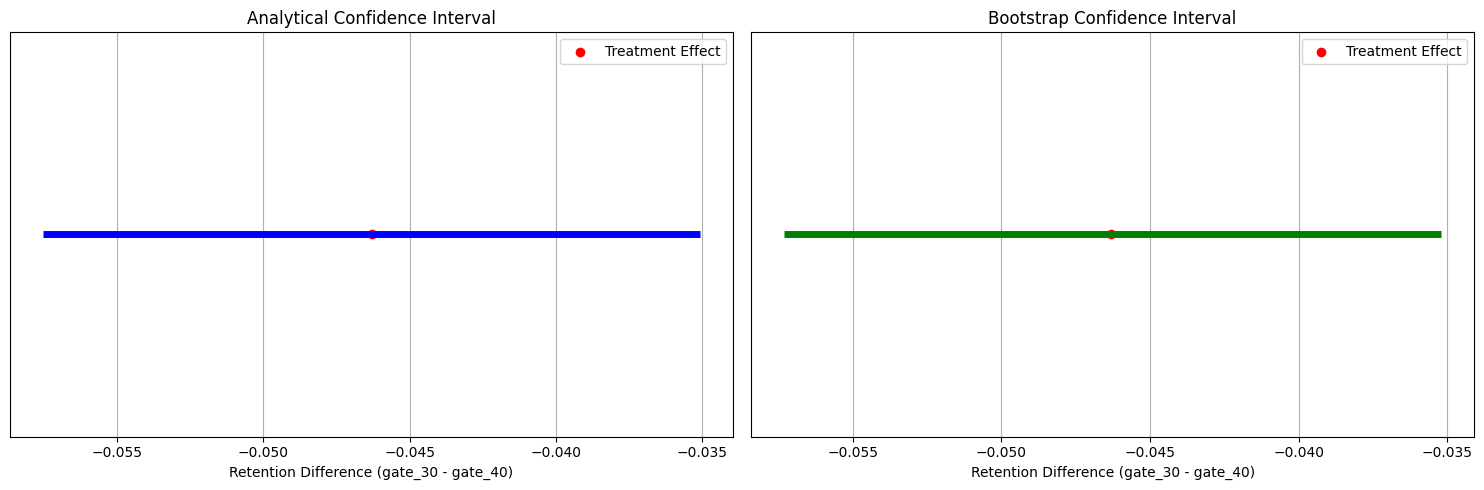

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hlines(
    1, ci_low_analytical_engaged, ci_high_analytical_engaged, color="blue", lw=5
)
axes[0].scatter(treatment_effect_engaged, 1, color="red", label="Treatment Effect")
axes[0].set_title("Analytical Confidence Interval")
axes[0].set_xlabel("Retention Difference (gate_30 - gate_40)")
axes[0].set_yticks([])
axes[0].legend()
axes[0].grid(True)

axes[1].hlines(
    1, ci_low_bootstrap_engaged, ci_high_bootstrap_engaged, color="green", lw=5
)
axes[1].scatter(treatment_effect_engaged, 1, color="red", label="Treatment Effect")
axes[1].set_title("Bootstrap Confidence Interval")
axes[1].set_xlabel("Retention Difference (gate_30 - gate_40)")
axes[1].set_yticks([])
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Comparison of Analytical and Bootstrap Confidence Intervals

- Both confidence intervals exclude zero, confirming that the difference in retention is statistically significant.
- The bootstrap CI is slightly wider, indicating that it captures more uncertainty than the analytical CI.
- Treatment Effect is negative, meaning `gate_40` had worse retention than `gate_30`. 


### Comparing Confidence interval for Whole dataset vs Engaged Players only


Bootstrap Confidence Interval (Whole Dataset - Day 7 Retention): (0.0033, 0.0134)
Bootstrap Confidence Interval (Engaged Players - Day 7 Retention): (-0.0575, -0.0351)


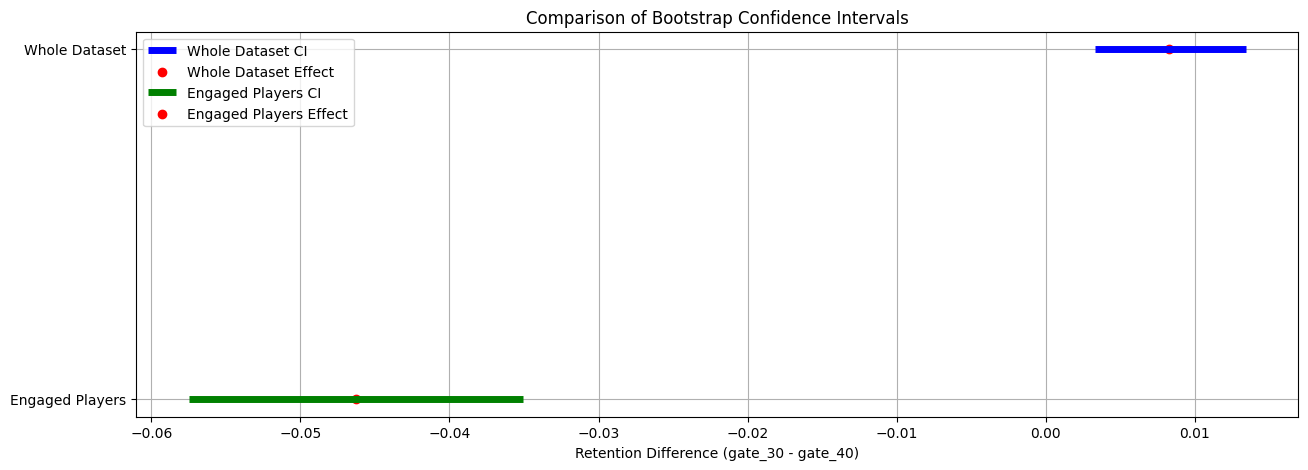

In [19]:
df_engaged = df[
    ((df['version'] == 'gate_30') & (df['sum_gamerounds'] >= 30)) |
    ((df['version'] == 'gate_40') & (df['sum_gamerounds'] >= 40))
]

retention_7_gate_30_all = df[df["version"] == "gate_30"]["retention_7"]
retention_7_gate_40_all = df[df["version"] == "gate_40"]["retention_7"]

retention_7_gate_30_engaged = df_engaged[df_engaged["version"] == "gate_30"]["retention_7"]
retention_7_gate_40_engaged = df_engaged[df_engaged["version"] == "gate_40"]["retention_7"]

n_30_all = len(retention_7_gate_30_all)
n_40_all = len(retention_7_gate_40_all)

n_30_engaged = len(retention_7_gate_30_engaged)
n_40_engaged = len(retention_7_gate_40_engaged)

n_boot = 10000
boot_diffs_all = []
boot_diffs_engaged = []

for _ in range(n_boot):
    boot_30_all = np.random.choice(retention_7_gate_30_all, size=n_30_all, replace=True)
    boot_40_all = np.random.choice(retention_7_gate_40_all, size=n_40_all, replace=True)
    boot_diffs_all.append(boot_30_all.mean() - boot_40_all.mean())

    boot_30_engaged = np.random.choice(retention_7_gate_30_engaged, size=n_30_engaged, replace=True)
    boot_40_engaged = np.random.choice(retention_7_gate_40_engaged, size=n_40_engaged, replace=True)
    boot_diffs_engaged.append(boot_30_engaged.mean() - boot_40_engaged.mean())

ci_low_bootstrap_all, ci_high_bootstrap_all = np.percentile(boot_diffs_all, [2.5, 97.5])
ci_low_bootstrap_engaged, ci_high_bootstrap_engaged = np.percentile(boot_diffs_engaged, [2.5, 97.5])

print(f"\nBootstrap Confidence Interval (Whole Dataset - Day 7 Retention): ({ci_low_bootstrap_all:.4f}, {ci_high_bootstrap_all:.4f})")
print(f"Bootstrap Confidence Interval (Engaged Players - Day 7 Retention): ({ci_low_bootstrap_engaged:.4f}, {ci_high_bootstrap_engaged:.4f})")

fig, ax = plt.subplots(figsize=(15, 5))

ax.hlines(2, ci_low_bootstrap_all, ci_high_bootstrap_all, color='blue', lw=5, label="Whole Dataset CI")
ax.scatter(np.mean(boot_diffs_all), 2, color='red', label="Whole Dataset Effect")

ax.hlines(1, ci_low_bootstrap_engaged, ci_high_bootstrap_engaged, color='green', lw=5, label="Engaged Players CI")
ax.scatter(np.mean(boot_diffs_engaged), 1, color='red', label="Engaged Players Effect")

ax.set_title("Comparison of Bootstrap Confidence Intervals")
ax.set_xlabel("Retention Difference (gate_30 - gate_40)")
ax.set_yticks([1, 2])
ax.set_yticklabels(["Engaged Players", "Whole Dataset"])
ax.legend()
ax.grid(True)

plt.show()


**Key Observations:**
1. **Whole Dataset CI (Blue Line)**
    - CI Range: (0.0031, 0.0133)
    - The confidence interval is entirely positive, suggesting a small but statistically significant positive effect of moving the gate.
    - This could be misleading because it includes players who never reached the gate, who may have dropped off early for unrelated reasons.

2. **Engaged Players CI (Green Line)**
    - CI Range: (-0.0575, -0.0353)
    - The confidence interval is entirely negative, showing that Gate 40 players had significantly lower retention than Gate 30 players.
    - Since this only includes players who actually saw the gate, this is likely a more accurate measure of the gate’s impact.

## Overall Conclusion and Recommendations

- The change in gate location (from level 30 to level 40) likely contributed to a decrease in player engagement and lower retention.

- The significant differences in game rounds played and retention rates suggest that the change was impactful enough to influence how players interacted with the game.

**Recommendations Moving Forward**

- **Experiment with New Gate Locations:**
    - The current change to level 40 did not yield positive results. It might be useful to test different gate locations or introduce other game features at different points to improve engagement.

- **Control for SRM:**
    - Ensure equal sample sizes across treatment and control groups to avoid bias. Resampling or weighting can help address the SRM issue detected earlier.

- **Conduct Further Engagement Analysis:**
    - Although the results suggest a negative impact, it is important to investigate why players dropped off in the Gate 40 group. Conducting qualitative research (such as surveys or user interviews) could provide deeper insights into player behavior.

- **A/B Test Iteration:**
    - Consider iterating the experiment based on these findings. Perhaps explore more granular changes to the gate or other engagement strategies to see if a more balanced design could improve retention.

**Final Thoughts:**
- The findings indicate that players are more engaged when the gate is at level 30, and the results suggest that further testing is necessary to refine game mechanics and optimize player retention.